# Meta Evaluation

This Notebook builds on top of the `1a_dataloader_example` and demonstrates
1. Evaluating accuracy performance for different network configurations

In [31]:
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from utils import plot

In [32]:
# %matplotlib widget
%matplotlib inline

## Network Definition

In [33]:
class Net(nn.Module):
    def __init__(self,
        N_in, N_out, N_hid,
        loss_func=nn.MSELoss(),
        LEARNING_RATE = 0.001,
        optimizer = optim.Adam,
        use_grad=False,
        act_func=nn.LeakyReLU()):
        
        super(Net, self).__init__()
        self.layers = nn.Sequential(
                nn.Linear(in_features=N_in,
                    out_features=N_hid,
                    bias=True),
                act_func,
                nn.Linear(in_features=N_hid,
                    out_features=N_out,
                    bias=True)
            )
        
        self.loss_func = loss_func
        self.optimizer = optimizer(self.parameters(), lr=LEARNING_RATE)
        self.use_grad = use_grad
        
    def forward(self, x):
        out = self.layers(x)
        return out

    def loss(self, x, y, y_grad=None):
        out = self.forward(x)
        loss = self.loss_func(y, out)
        if self.use_grad:
            out_grad = torch.autograd.grad(out, x, torch.ones(x.shape), create_graph=True)[0]
            loss += self.loss_func(y_grad, out_grad)
        return loss
    
    def step(self, x, y, y_grad=None):
        self.train()
        self.optimizer.zero_grad()
        loss = self.loss(x, y, y_grad)
        loss.backward(retain_graph=True)
        self.optimizer.step()
        self.eval()
        return loss.detach()

## 1D

### Define Dataset 

In [34]:
from DatasetFunction1D_advanced import DatasetFunction1D, func_types

number_of_functions = len(func_types)
datasets = []

for i, func_type in enumerate(func_types):
    # Define dataset
    x = torch.linspace(-3,3, 100, requires_grad=True).reshape(-1,1)
    dataset = DatasetFunction1D(x, func_type=func_type)
    datasets.append(dataset)

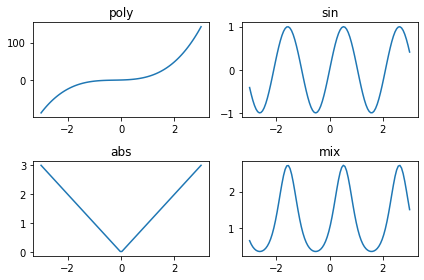

In [35]:
for i, func_type in enumerate(func_types):
    x, y, y_grad = datasets[i][:]
    plt.subplot(int(number_of_functions/2),2,i+1)
    plot(x, y)
    plt.title(func_type)

plt.tight_layout()

### Holdout Validation

In [36]:
batch_size = 10
epochs = 500

In [37]:
from torch.utils.data import DataLoader
from sklearn.model_selection import ShuffleSplit
from torch.utils.data import SubsetRandomSampler

def train(dataset):
    x, y, y_grad = dataset[:]
    N_in = x.shape[1]
    N_out = y.shape[1]

    # Split dataset into train and test set (without stratification).
    shuffleSplit = ShuffleSplit(n_splits=1, test_size=.25).split(x)
    train_ids, test_ids = next(iter(shuffleSplit))

    train_sampler = SubsetRandomSampler(train_ids)
    train_loader = torch.utils.data.DataLoader(
                        dataset, 
                        batch_size=batch_size,
                        sampler=train_sampler)

    net = Net(N_in, N_out, N_hid=100, use_grad=True)

    losses_train = torch.zeros(epochs)
    losses_test = torch.zeros(epochs)

    for epoch in range(epochs):
        current_loss = 0.0
        for i, batch in enumerate(train_loader):
            x_train, y_train, y_train_grad = batch
            current_loss += net.step(x_train, y_train, y_train_grad)
        losses_train[epoch] = current_loss / len(train_loader)
        
        # Evaluation against test set
        x_test, y_test, y_grad_test = dataset[test_ids]
        losses_test[epoch] = net.loss(x_test, y_test, y_grad_test)

    return losses_train, losses_test, net

In [38]:
trains = [train(dataset) for dataset in datasets]

### Evaluation

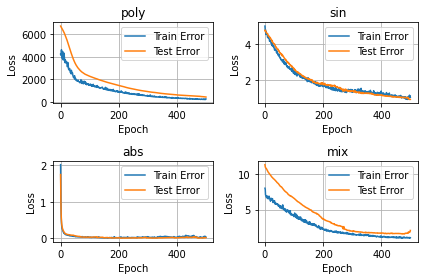

In [39]:
for i, func_type in enumerate(func_types):
    losses_train, losses_test, _ = trains[i]

    plt.subplot(int(number_of_functions/2),2,i+1)

    plot(range(epochs), losses_train)
    plot(range(epochs), losses_test)
    plt.title(func_type)
    plt.legend(['Train Error', 'Test Error'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()

plt.tight_layout()

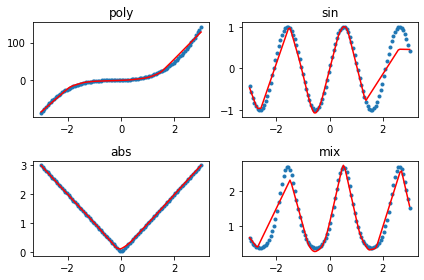

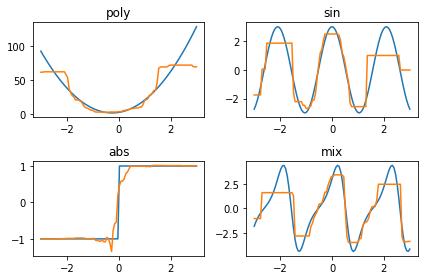

In [40]:
for i, func_type in enumerate(func_types):
    _, _, net = trains[i]
    x, y, y_grad = datasets[i][:]
    
    plt.figure(1)
    plt.subplot(int(number_of_functions/2),2,i+1)
    plt.title(func_type)
    out = net(x)
    plot(x, y, '.')
    plot(x, out, 'r')
    plt.tight_layout()

    f = plt.figure(2)
    plt.subplot(int(number_of_functions/2),2,i+1)
    plt.title(func_type)
    out_grad = torch.autograd.grad(net(x), x, torch.ones(x.shape))[0]
    plot(x,y_grad)
    plot(x,out_grad)
    plt.tight_layout()